# import modules and define global parameters¶

In [5]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import tensorly as tl
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from keras import models
from keras import layers
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline

num_test = 234*2*39
num_drug_a = 38
num_drug_b = 38
num_cell_line = 39
num_compo = 1000
num_predict = 240 * num_cell_line
methods = ['dnn','cpwopt','log','rf']


Using TensorFlow backend.


# read data preprocessed by R

In [31]:
final_tensor = tl.tensor(np.arange(39*38*38).reshape((39, 38, 38)),dtype=tl.float32)
for i in range(0,39):
    to_open = '/Users/apple/Desktop/mi_code/R/tensor_'+ str(i+1) + '.csv'
    tmp_tensor = pd.read_csv(to_open)
    tmp_tensor = tmp_tensor.drop('Unnamed: 0',axis = 1)
    final_tensor[i] = tmp_tensor.values

# calculate missing index

In [32]:
test = pd.read_csv(to_open)
test = test.drop('Unnamed: 0',axis = 1)
nan_set = {}
test_cal = test.copy()
test_cal[np.isnan(test_cal)]  = 1000
num = 0
for i in range(38):
    for j in range(i+1,38):
        if(test_cal.iloc[i,j] == 1000):
            num = num + 1
            if  not i in nan_set.keys():
                nan_set[i] = set()
            nan_set[i].add(j)
nan_set[0].add(0)

In [33]:
num_predict = 240*num_cell_line;
miss_index = []
miss_list = list(nan_set[0])
for i in range(16):
    for j in range(i+1,16):
        for z in range(39):
            miss_index_to_add_1 = miss_list[i] + num_drug_a*miss_list[j] + num_drug_a*num_drug_b*z
            miss_index.append(miss_index_to_add_1)
            miss_index_to_add_2 = miss_list[j] + num_drug_b*miss_list[i] + num_drug_a*num_drug_b*z
            miss_index.append(miss_index_to_add_2)
miss_index.sort()
np.savetxt('/Users/apple/Desktop/tensor_pro/data/miss_index.txt',miss_index)

# define useful functions

In [9]:
def save_txt(num_exp,data_name,data,folder_class = 2):
    if folder_class == 1:
        folder_name = '/Users/apple/Desktop/tensor_pro/data/'
    else:
        folder_name ='/Users/apple/Desktop/tensor_pro/data/exp' + str(num_exp)+'/' 
    if type(data) is np.float64:
        data = np.array(data).reshape(1,1)

    to_save = folder_name + data_name +'.txt'
    np.savetxt(to_save,data)

def read_txt(num_exp,data_name,folder_class = 2):
    if folder_class == 1:
        folder_name = '/Users/apple/Desktop/tensor_pro/data/'
    else:
        folder_name ='/Users/apple/Desktop/tensor_pro/data/exp' + str(num_exp)+'/'
    to_read = folder_name + data_name + '.txt'
    return np.loadtxt(to_read)


def pre_feature_label(num_exp ):
    folder_name = '/Users/apple/Desktop/tensor_pro/data/exp' + str(num_exp)+'/'
    to_read = folder_name+'durg_a.csv'
    drug_a = pd.read_csv(to_read,header= None)
    to_read = folder_name+'durg_b.csv'
    drug_b = pd.read_csv(to_read,header = None)
    to_read = folder_name+'cell_line.csv'
    cell_line = pd.read_csv(to_read,header = None)
    feature = np.zeros(shape = (num_drug_a*num_drug_b*num_cell_line,num_compo,3,))
    labels = np.zeros(shape = (num_drug_a*num_drug_b*num_cell_line))
    for z in range(num_cell_line):
        for y in range(num_drug_b):
            for x in range(num_drug_a):
                index = z*num_drug_a*num_drug_b + y*num_drug_a + x
                feature[index,:,0] = drug_a.values[x,:]
                feature[index,:,1] = drug_b.values[y,:]
                feature[index,:,2] = cell_line.values[z,:]
                labels[index] = final_tensor[z,x,y]
    
    labels[miss_index]  = 0     
    final_feature = np.zeros(shape = (38*38*39,1000*3))
    for i in range(38*38*39):
        final_feature[i,:] = feature[i,:,:].flatten(order = 'F')
    

    return final_feature,labels


def cal_test_index(num_exp):
    test_index = []
    folder_name ='/Users/apple/Desktop/tensor_pro/data/exp' + str(num_exp)+'/'
    for i in range(39):
        data_tmp_name = folder_name+'tensor'+str(i+1)+'.csv'
        tmp_data = pd.read_csv(data_tmp_name)
        tmp_data = tmp_data.drop('Unnamed: 0',axis = 1).values
        length = len(tmp_data)

        for k in range(length):
            x, y = tmp_data[k] % num_drug_a, tmp_data[k] // num_drug_a
            to_add_test_index_1 = x * num_drug_a + y + num_drug_a*num_drug_b*i
            test_index.append(to_add_test_index_1)
            to_add_test_index_2 = x  + y*num_drug_b + num_drug_a*num_drug_b*i
            test_index.append(to_add_test_index_2)

    for i in range(len(test_index)):
        test_index[i] = int(test_index[i])
    test_index.sort()
    #save_txt(num_exp,'test_index',test_index)
    return test_index

def pre_train_test(num_exp):
    
    final_feature,labels = pre_feature_label(num_exp)
    test_index = cal_test_index(num_exp)
#     test_synergy = labels[test_index].copy()
#     save_txt(num_exp,'test_synergy',test_synergy)
    
    labels[labels <= 30]  = 0
    labels[labels >  30]  = 1
    labels = labels.astype(np.int16)
    
    test_feature = np.zeros(shape = (num_test,3*num_compo))
    test_feature = final_feature[test_index,:].copy()
    test_labels = labels[test_index].copy()
    save_txt(num_exp,'test_labels',test_labels)
    
    miss_feature = np.zeros(shape = (num_predict, 3*num_compo))
    miss_feature = final_feature[miss_index,:].copy()
    
    to_delete_index = test_index + miss_index
    to_delete_index.sort()
    train_labels  = np.delete(labels,to_delete_index)
    train_feature = np.delete(final_feature,to_delete_index, axis = 0)
    
    
    return train_feature,train_labels,test_feature,test_labels,miss_feature



def multi_methods(train_feature,train_labels,test_feature,test_labels,miss_feature,fun_name,num_exp):
    folder_name = '/Users/apple/Desktop/tensor_pro/data/exp' + str(num_exp)+'/'
    #acc = None
    
    
    if fun_name =='dnn':
    
        model = models.Sequential()
        model.add(layers.Dense(1024,activation = 'relu',input_shape = (3000,)))
        model.add(layers.Dense(128, activation='relu'))
        model.add(layers.Dense(128, activation='relu'))
        model.add(layers.Dense(128, activation='relu'))
        model.add(layers.Dense(128, activation='relu'))
        model.add(layers.Dense(128, activation='relu'))
        model.add(layers.Dense(1024, activation='relu'))
        model.add(layers.Dense(1024, activation='relu'))
        model.add(layers.Dense(1, activation='sigmoid'))
        #model = build_model()
        model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])
        num_epochs = 10
        model.fit(train_feature ,train_labels,epochs=num_epochs,batch_size=2048)
        test_pre = model.predict(test_feature)
        miss_pre = model.predict(miss_feature)
        
        save_txt(num_exp,'dnn_test_pre',test_pre)
        save_txt(num_exp,'dnn_miss_pre',miss_pre)
        
        
        acc_pre = test_pre.copy()
        acc_pre[acc_pre <= 0.5] = 0
        acc_pre[acc_pre > 0.5] = 1
        acc_pre = acc_pre.astype(np.int16)
        acc_pre = acc_pre[:,0]
        #return acc_pre
        
        acc = (1 - np.sum(acc_pre != test_labels) / num_test) * 100
        save_txt(num_exp,'dtf_acc',acc)
        
        fpr,tpr,thresholds = roc_curve(y_true = test_labels, y_score = test_pre)
        auc_value = auc(fpr,tpr)
        save_txt(num_exp,'dtf_auc',auc_value)
        
    elif fun_name == 'cpwopt':
        to_read = folder_name + 'cpwopt_true.csv'
        true_cpwopt = pd.read_csv(to_read,header= None).values[0]
        to_read = folder_name + 'cpwopt_pre.csv'
        pre_cpwopt = pd.read_csv(to_read,header= None).values[0]
        
        true_cpwopt_label = true_cpwopt.copy()
        true_cpwopt_label[true_cpwopt_label<30] = 0
        true_cpwopt_label[true_cpwopt_label>=30] = 1
        true_cpwopt_label = true_cpwopt_label.astype(np.int16)
        pre_cpwopt_class = pre_cpwopt.copy()
        pre_cpwopt_class[pre_cpwopt_class < 30] = 0
        pre_cpwopt_class[pre_cpwopt_class >= 30 ] = 1
        pre_cpwopt_class = pre_cpwopt_class.astype(np.int16)
        
        save_txt(num_exp,'cpwopt_test_pre',pre_cpwopt)
        save_txt(num_exp,'cpwopt_test_label',true_cpwopt_label)
        
        acc = (1 - np.sum(pre_cpwopt_class != true_cpwopt_label) / num_test) *100
        save_txt(num_exp,'cpwopt_acc',acc)
        
        
        fpr,tpr,thresholds = roc_curve(y_true = true_cpwopt_label, y_score = pre_cpwopt)
        auc_value = auc(fpr,tpr)
        save_txt(num_exp,'cpwopt_auc',auc_value)

    elif fun_name =='log':
        
        lg_clf = LogisticRegression(solver='lbfgs',max_iter = 1000)
        lg_clf.fit(train_feature ,train_labels)
        test_pre = lg_clf.predict_proba(test_feature)[:,1]
        miss_pre = lg_clf.predict(miss_feature)
        
        save_txt(num_exp,'log_test_pre',test_pre)
        save_txt(num_exp,'log_miss_pre',miss_pre)
        
        pre_class = lg_clf.predict(test_feature)
        acc = lg_clf.score(test_feature,test_labels)
        save_txt(num_exp,'log_acc',acc)
        
        fpr,tpr,thresholds = roc_curve(y_true = test_labels, y_score = test_pre)
        auc_value = auc(fpr,tpr)
        save_txt(num_exp,'log_auc',auc_value)
        
    elif fun_name =='rf':

        clf_forest = RandomForestClassifier(n_estimators=70, max_depth=7,
                         random_state=0)
        clf_forest.fit(train_feature ,train_labels)
        test_pre = clf_forest.predict_proba(test_feature)[:,1]
        miss_pre = clf_forest.predict(miss_feature)
        
        save_txt(num_exp,'rf_test_pre',test_pre)
        save_txt(num_exp,'rforest_miss_pre',miss_pre)
        
        pre_class = clf_forest.predict(test_feature)
        acc = clf_forest.score(test_feature,test_labels)
        save_txt(num_exp,'rf_acc',acc)
        
        fpr,tpr,thresholds = roc_curve(y_true = test_labels, y_score = test_pre)
        auc_value = auc(fpr,tpr)
        save_txt(num_exp,'rf_auc',auc_value)

# final model no test set + missing table

In [8]:
def build_model():
    #inita = initializers.glorot_uniform(seed = 999)
    model = models.Sequential()
    model.add(layers.Dense(1024,activation = 'relu',input_shape = (3000,),))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [9]:
from sklearn.preprocessing import MinMaxScaler
folder_name = '/Users/apple/Desktop/tensor_pro/final_results/'
to_read = folder_name+'durg_a.csv'
drug_a = pd.read_csv(to_read,header= None)
to_read = folder_name+'durg_b.csv'
drug_b = pd.read_csv(to_read,header = None)
to_read = folder_name+'cell_line.csv'
cell_line = pd.read_csv(to_read,header = None)
feature = np.zeros(shape = (num_drug_a*num_drug_b*num_cell_line,num_compo,3,))
labels = np.zeros(shape = (num_drug_a*num_drug_b*num_cell_line))
for z in range(num_cell_line):
    for y in range(num_drug_b):
        for x in range(num_drug_a):
            index = z*num_drug_a*num_drug_b + y*num_drug_a + x
            feature[index,:,0] = drug_a.values[x,:]
            feature[index,:,1] = drug_b.values[y,:]
            feature[index,:,2] = cell_line.values[z,:]
            labels[index] = final_tensor[z,x,y]
# scaler = MinMaxScaler()
# scaler.fit(fi)
labels[miss_index]  = 0     
labels[labels <= 30]  = 0
labels[labels >  30]  = 1
labels = labels.astype(np.int16)
final_feature = np.zeros(shape = (38*38*39,1000*3))
for i in range(38*38*39):
    final_feature[i,:] = feature[i,:,:].flatten(order = 'F')
miss_feature = np.zeros(shape = (num_predict, 3*num_compo))
miss_feature = final_feature[miss_index,:].copy()
train_labels  = np.delete(labels,miss_index)
np.savetxt(folder_name + 'train_labels.txt',train_labels)
train_feature = np.delete(final_feature,miss_index, axis = 0)

In [8]:
folder_name = '/Users/apple/Desktop/tensor_pro/final_results/'
drug_names =  pd.read_csv(folder_name+'drug_names.csv')
drug_names = drug_names.drop('Unnamed: 0',axis=1)
drug_names = drug_names.values[:,0]
cell_line_names = pd.read_csv(folder_name+'cell_line_names.csv')
cell_line_names = cell_line_names.drop('Unnamed: 0',axis=1)
cell_line_names = cell_line_names.values[:,0]
cell_line_cancer  = pd.read_csv(folder_name + '39_celllines_information.csv')
cell_line_to_cancer = {}
to_cell_line = cell_line_cancer.loc[:,'Cell line']
to_cancer  = cell_line_cancer.loc[:,'Indication']
for i in range(39):
    cell_line_to_cancer[to_cell_line[i]]  = to_cancer[i]

def ret_index(num):
    z = num // (38*38)
    res = num % (38*38)
    y = res // 38
    x = res % 38
    return x,y,z

def ret_ori_name(num):
    x,y,z = ret_index(num)
    return drug_names[x],drug_names[y],cell_line_names[z]



In [15]:
model = build_model()

model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])
num_epochs = 10
model.fit(train_feature ,train_labels,epochs=num_epochs,batch_size=2048)
miss_pre = model.predict(miss_feature)
#np.savetxt(folder_name + 'miss_pre.txt',miss_pre)
train_pre = model.predict(train_feature)
#np.savetxt(folder_name + 'train_pre.txt',train_pre)




Epoch 1/10
46956/46956 [==============================] - 13s 285us/step - loss: 0.3032 - acc: 0.9155
Epoch 2/10
46956/46956 [==============================] - 14s 295us/step - loss: 0.2130 - acc: 0.9160
Epoch 3/10
46956/46956 [==============================] - 17s 359us/step - loss: 0.1792 - acc: 0.9303
Epoch 4/10
46956/46956 [==============================] - 15s 312us/step - loss: 0.1474 - acc: 0.9430
Epoch 5/10
46956/46956 [==============================] - 20s 417us/step - loss: 0.1254 - acc: 0.9502
Epoch 6/10
46956/46956 [==============================] - 17s 370us/step - loss: 0.1022 - acc: 0.9594
Epoch 7/10
46956/46956 [==============================] - 15s 318us/step - loss: 0.0897 - acc: 0.9627
Epoch 8/10
46956/46956 [==============================] - 12s 247us/step - loss: 0.0730 - acc: 0.9703
Epoch 9/10
46956/46956 [==============================] - 13s 280us/step - loss: 0.0610 - acc: 0.9753
Epoch 10/10
46956/46956 [==============================] - 14s 296us/step - loss: 

# calculate the pairs whose symmetrical pairs are both of probability above 0.5

In [15]:
num_all =  int(len(miss_index) / 2)
num_max = 1000
table_data = {'Cell line':[],'Cancer':[],'Drug A':[],'Drug B':[],'Probility for strong synergy':[]}
miss_pre = np.loadtxt(folder_name + 'miss_pre.txt')
#model = load_model(folder_name + 'final_model.h5')
#miss_pre = model.predict(miss_feature)[:,0]
miss_index  = read_txt(1,'miss_index',1)
miss_index = miss_index.astype(np.int32)
miss_index = miss_index.tolist()
for i in range(num_all):
    tmp_max = np.argmax(miss_pre)
    max_val = np.max(miss_pre)
    x,y,z = ret_index(miss_index[tmp_max])
    #print(x,y,z)
    if max_val >= 0.5:
        to_append = miss_pre[tmp_max].copy()
        miss_pre[tmp_max] = 0
        sym_index = x * num_drug_a + y + z*num_drug_a*num_drug_b
        to_zero = miss_index.index(sym_index)
        if  miss_pre[to_zero] >= 0.5:
            drug_a,drug_b,cell_line = ret_ori_name(miss_index[tmp_max])
            table_data['Cell line'].append(cell_line)
            table_data['Drug A'].append(drug_a)
            table_data['Drug B'].append(drug_b)
            table_data['Probility for strong synergy'].append(to_append)
            #miss_pre[tmp_max] = 0
    #         sym_index = x * num_drug_a + y + z*num_drug_a*num_drug_b
    #         to_zero = miss_index.index(sym_index)
            miss_pre[to_zero] = 0
            table_data['Cancer'].append(cell_line_to_cancer[cell_line])

to_frame = pd.DataFrame(table_data)
to_frame = to_frame.sort_values(by = ['Cancer','Cell line'])
to_frame

,Cell line,Cancer,Drug A,Drug B,Probility for strong synergy
30,KPL1,Breast,VINBLASTINE,DEXAMETHASONE,0.922497
62,KPL1,Breast,DEXAMETHASONE,SN-38,0.626805
40,T47D,Breast,METFORMIN,SN-38,0.865062
54,T47D,Breast,DOXORUBICIN,METFORMIN,0.784404
61,T47D,Breast,METFORMIN,5-FU,0.661742
64,T47D,Breast,METFORMIN,CARBOPLATIN,0.587014
65,T47D,Breast,5-FU,SN-38,0.577246
52,ZR751,Breast,PACLITAXEL,DEXAMETHASONE,0.794870
53,ZR751,Breast,ETOPOSIDE,DEXAMETHASONE,0.786935
63,RKO,Colon,CARBOPLATIN,TOPOTECAN,0.621036


# calculate the pairs, one of whose symmetrical pairs is of probability above 0.5

In [13]:
num_all =  int(len(miss_index) / 2)
num_max = 1000
table_data = {'Cell line':[],'Cancer':[],'Drug A':[],'Drug B':[],'Probility for strong synergy':[]}
miss_pre = np.loadtxt(folder_name + 'miss_pre.txt')
#model = load_model(folder_name + 'final_model.h5')
#miss_pre = model.predict(miss_feature)[:,0]
miss_index  = read_txt(1,'miss_index',1)
miss_index = miss_index.astype(np.int32)
miss_index = miss_index.tolist()
for i in range(num_all):
    tmp_max = np.argmax(miss_pre)
    max_val = np.max(miss_pre)
    x,y,z = ret_index(miss_index[tmp_max])
    to_append = max_val 
    #print(x,y,z)
    if max_val >= 0.5:
        drug_a,drug_b,cell_line = ret_ori_name(miss_index[tmp_max])
        table_data['Cell line'].append(cell_line)
        table_data['Drug A'].append(drug_a)
        table_data['Drug B'].append(drug_b)
        #table_data['Probility for strong synergy'].append(miss_pre[tmp_max])
        miss_pre[tmp_max] = 0
        sym_index = x * num_drug_a + y + z*num_drug_a*num_drug_b
        to_zero = miss_index.index(sym_index)
        to_append = max(max_val,miss_pre[to_zero])
        miss_pre[to_zero] = 0
        table_data['Probility for strong synergy'].append(to_append)
        table_data['Cancer'].append(cell_line_to_cancer[cell_line])
    
to_frame = pd.DataFrame(table_data)
to_frame = to_frame.sort_values(by = ['Cancer','Cell line'])
to_frame

,Cell line,Cancer,Drug A,Drug B,Probility for strong synergy
160,EFM192B,Breast,VINBLASTINE,SN-38,0.575771
31,KPL1,Breast,ETOPOSIDE,DEXAMETHASONE,0.948097
42,KPL1,Breast,VINBLASTINE,DEXAMETHASONE,0.922497
130,KPL1,Breast,DEXAMETHASONE,SN-38,0.626805
131,KPL1,Breast,VINORELBINE,DEXAMETHASONE,0.623398
140,KPL1,Breast,VINBLASTINE,SN-38,0.615618
105,OCUBM,Breast,CARBOPLATIN,DEXAMETHASONE,0.729897
137,OCUBM,Breast,CARBOPLATIN,CYCLOPHOSPHAMIDE,0.618844
147,OCUBM,Breast,DEXAMETHASONE,SN-38,0.593470
172,OCUBM,Breast,SN-38,CARBOPLATIN,0.549131


In [14]:
to_frame.to_csv(folder_name+'final_result_pre_miss.csv')

In [15]:
from keras.models import load_model

In [17]:
curr_model = load_model(folder_name + 'final_model.h5')

W0919 21:20:14.246341 4672447936 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:2463: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0919 21:20:14.473195 4672447936 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0919 21:20:14.479835 4672447936 deprecation.py:323] From /Users/apple/Library/Python/3.7/lib/python/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# calculate negative and positive sizes for each cell line

In [14]:
drug_names =  pd.read_csv(folder_name+'drug_names.csv')
drug_names = drug_names.drop('Unnamed: 0',axis=1)
drug_names = drug_names.values[:,0]
cell_line_names = pd.read_csv(folder_name+'cell_line_names.csv')
cell_line_names = cell_line_names.drop('Unnamed: 0',axis=1)
cell_line_names = cell_line_names.values[:,0]

In [18]:
train_labels.shape

(46956,)

In [19]:
(38*38 - 240)*39

46956

In [22]:
train_labels = np.loadtxt('/Users/apple/Desktop/tensor_pro/final_results/train_labels.txt')
num_each = (38*38 - 240)
cell_line_pos_neg = {'cell_line':[],'positive_size':[],'negative_size':[]}
for i in range(39):
    tmp_pos = np.sum(train_labels[i*num_each:(i+1)*num_each])
    tmp_neg = (38*38 - 38 - 240) - tmp_pos
    cell_line_pos_neg['cell_line'].append(cell_line_names[i]) 
    cell_line_pos_neg['positive_size'].append(int(tmp_pos/2))
    cell_line_pos_neg['negative_size'].append(int(tmp_neg/2))
to_save = pd.DataFrame(cell_line_pos_neg)
to_save.to_csv(folder_name + 'cell_line_pos_neg.csv',index = False)

In [12]:
(38*38 - 38 - 240)/2

583.0

# Calculate negative and positive sizes for missing pairs of each cell line. One of the symmetrical pairs has the probability above 0.5 is regarded as positive for missing pairs

In [28]:
miss_pre = np.loadtxt('/Users/apple/Desktop/tensor_pro/final_results/miss_pre.txt')

In [35]:
def ret_index(num):
    z = num // (38*38)
    res = num % (38*38)
    y = res // 38
    x = res % 38
    return x,y,z

miss_pre = np.loadtxt('/Users/apple/Desktop/tensor_pro/final_results/miss_pre.txt')
miss_pre_pos_neg = {'cell_line':[],'positive_size':[0]*39,'negative_size':[0]*39}
for i in range(39):
    tmp_pre = miss_pre[i*240:(i+1)*240]
    tmp_index = miss_index[i*240:(i+1)*240]
    tmp_pos = 0
    for k in range(240):
        tmp_max = np.argmax(tmp_pre)
        if  tmp_pre[tmp_max] >= 0.5:
            tmp_pos += 1
            x,y,z = ret_index(tmp_index[tmp_max])
            tmp_pre[tmp_max] = 0
            sym_index = x * num_drug_a + y + num_drug_a*num_drug_b*i
            to_zero = tmp_index.index(sym_index)
            tmp_pre[to_zero] = 0            
    miss_pre_pos_neg['cell_line'].append(cell_line_names[i]) 
    miss_pre_pos_neg['positive_size'][i] = tmp_pos
    miss_pre_pos_neg['negative_size'][i] = 120 - tmp_pos
to_save = pd.DataFrame(miss_pre_pos_neg)
to_save.to_csv(folder_name + 'miss_pre_pos_neg.csv',index = False)

In [36]:
pd.read_csv(folder_name + 'miss_pre_pos_neg.csv')

,cell_line,positive_size,negative_size
0,A2058,1,119
1,A2780,0,120
2,A375,8,112
3,A427,0,120
4,CAOV3,23,97
5,COLO320DM,2,118
6,DLD1,0,120
7,EFM192B,1,119
8,ES2,12,108
9,HCT116,0,120


# Draw bar plots for negative and positive samples for each cell line (existing pairs)

W0927 11:42:24.331794 4450760128 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0927 11:42:24.332545 4450760128 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0927 11:42:24.605458 4450760128 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0927 11:42:24.606138 4450760128 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


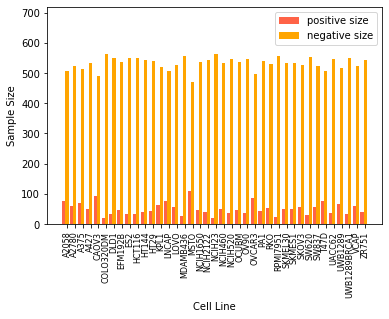

In [25]:
to_draw = pd.read_csv(folder_name + 'cell_line_pos_neg.csv')
name_list = to_draw['cell_line'].tolist()
num_list = to_draw['positive_size'].tolist()
num_list1 = to_draw['negative_size'].tolist()
x =list(range(len(num_list)))
total_width, n = 0.8, 2
width = total_width / n
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.bar(x, num_list, width=width, label='positive size',fc = 'tomato')
for i in range(len(x)):
    x[i] = x[i] + width
ax.bar(x, num_list1, width=width, label='negative size',tick_label = name_list,fc = 'orange')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90,fontsize= 8)
plt.legend(loc = 'best')
plt.ylim([0, 720])
plt.xlabel('Cell Line')
plt.ylabel('Sample Size')
plt.savefig('/Users/apple/Desktop/tensor_pro/figures/cell_line_neg_pos.eps'
            ,dpi=1000,format='eps', bbox_inches = 'tight')
plt.show()

# Draw bar plots for negative and positive samples for each cell line (missing pairs)

In [34]:
to_draw = pd.read_csv(folder_name + 'miss_pre_pos_neg.csv')
name_list = to_draw['cell_line'].tolist()
num_list = to_draw['positive_size'].tolist()
num_list1 = to_draw['negative_size'].tolist()
x =list(range(len(num_list)))
total_width, n = 0.8, 2
width = total_width / n
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.bar(x, num_list, width=width, label='positive size',fc = 'tomato')
for i in range(len(x)):
    x[i] = x[i] + width
ax.bar(x, num_list1, width=width, label='negative size',tick_label = name_list,fc = 'orange')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90,fontsize= 8)
plt.legend(loc ='best')
plt.ylim([0,155])
plt.xlabel('Cell Line')
plt.ylabel('Sample Size')
plt.savefig('/Users/apple/Desktop/tensor_pro/figures/miss_pre_neg_pos.eps'
            ,dpi=1000,format='eps', bbox_inches = 'tight')
plt.show()

FileNotFoundError: [Errno 2] File b'/Users/apple/Desktop/tensor_pro/final_results/miss_pre_pos_neg.csv' does not exist: b'/Users/apple/Desktop/tensor_pro/final_results/miss_pre_pos_neg.csv'